In [1]:
import numpy as np
from scipy.signal import convolve2d 
from os import path, getcwd, system, getenv
from astropy.io import fits
from time import perf_counter
import urllib.request

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import matplotlib.gridspec as gridspec

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import sys,inspect
currentdir = path.dirname(path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = path.dirname(currentdir)
sys.path.append(parentdir)
# from deconv import cube_deconv
# from ppxf_wrap import ppxf_wrap

# import warnings

# if True:
#     print('Set warnings.filterwarnings as "ignore"')
#     print('Warning Message will not be printed')
#     warnings.filterwarnings("ignore")

from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import constants
import pandas as pd

# import plotly.express as px
from astroquery.mast import Observations


from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.nddata.utils import Cutout2D

from astropy.wcs import WCS
import astropy

In [2]:
def set_rcparams_prop(amp=1, fs=22, tickamp=None):
#     fs=18
    if tickamp==None:
        tickamp=amp
    tickmajorwidth=2.5*amp
    tickminorwidth=2.5*amp
    axeslw=2.5*amp
    tmjs=6*tickamp
    tmns=tmjs/3.5*2
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

In [3]:

obs_table = Observations.query_region("322.49324 12.16683")

In [4]:
objnames=['M 82','NGC 7090','NGC 4736','NGC 5055','NGC 2403',
          'NGC 5194','M 101','NGC 3031','NGC 6744','NGC 253',
          'NGC 3079','NGC 5866','NGC 4151','NGC 1313',
          'NGC 4631','NGC 891'
         ]

obs_tables=[]
for objname in objnames:
    print(objname)
    obs_tables.append(Observations.query_criteria(obs_collection='FUSE',objectname=objname, radius=".5 deg"))
# objname='NGC4631'
# obs_table = Observations.query_criteria(filters=["FUV","GALEX"],objectname=objname, radius=".02 deg")
# obs_table = Observations.query_criteria(filt=["FUSE"],objectname=objname, radius=".5 deg")
obs_table = Observations.query_criteria(obs_collection='FUSE',objectname="NGC4631", radius=".5 deg")


M 82
NGC 7090
NGC 4736
NGC 5055
NGC 2403
NGC 5194
M 101
NGC 3031
NGC 6744
NGC 253
NGC 3079
NGC 5866
NGC 4151
NGC 1313
NGC 4631
NGC 891


In [5]:

# Table: 
# Galaxy, Program ID, N pointings (exp >5000s), RA, DEC, Max Exp, Mean Exp
# *note on aperture
# *RA DEC unit check

print(obs_tables[0]['target_name'])
obs_tables[0].colnames
obs_tables[4]

exptimes=obs_tables[4]['t_exptime']
print(exptimes)
cond=exptimes>5000
# print(obs_tables[4][cond])
fexptimes=obs_tables[4][cond]['t_exptime']
# cond
print(obs_tables[4][0])
down_dir='/home/hchung/fuse/temp/'
pl=Observations.get_product_list(obs_tables[4])
# np.sum(pl['productType']=="SCIENCE")
# pl.colnames
urls=pl['dataURI']
rr=[x.find('00000all4ttag') for x in urls]

target_name
-----------
      M82-A
      M82-B
      M82-C
      M82-D
t_exptime
---------
  21890.0
  17172.0
  18372.0
  30420.0
   1394.0
  16380.0
   6692.0
dataproduct_type calib_level obs_collection    obs_id    target_name         s_ra          s_dec       t_min          t_max     t_exptime wavelength_region filters     em_min        em_max     target_classification                  obs_title                   t_obs_release instrument_name proposal_pi proposal_id proposal_type project sequence_number provenance_name                      s_region                                                          jpegURL                                                                         dataURL                                     dataRights mtFlag srcDen intentType obsid  objID  objID1      distance     
---------------- ----------- -------------- ----------- ------------- ------------------ --------- -------------- ------------- --------- ----------------- ------- ------------- -----

In [6]:
pl['obs_id']
pl.colnames

['obsID',
 'obs_collection',
 'dataproduct_type',
 'obs_id',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project',
 'prvversion',
 'proposal_id',
 'productFilename',
 'size',
 'parent_obsid',
 'dataRights',
 'calib_level']

In [7]:
urls

mast:FUSE/url/pub/fuse/data/f9180202/f9180202001fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202002fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202003fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202004fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202005fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202006fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202701fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f91802020011attagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f91802020011bttagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f91802020012attagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f91802020012bttagfraw.fit.gz


In [8]:
aa=np.array(rr)
print(np.sum(aa>0))
obs_tables[4]

urls[aa>0]
# pl
pl['productFilename']

fnames=[]


#download files
down_dir='/home/hchung/fuse/temp/'
for i in range(len(obs_tables)):
# for i in [6]:
    otb=obs_tables[i]
    pl=Observations.get_product_list(obs_tables[i])
    urls=pl['dataURI']
    rr=[x.find('00000all2ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    print(urls)
    manifest = Observations.download_products(dpl, download_dir=down_dir)
    print(obs_tables[i]['target_name'])
    print(manifest)
    
#     rr=[x.find('00000all2ttag') for x in urls]
#     dpl=pl[np.array(rr)>0]
#     print(urls)
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(obs_tables[i]['target_name'])
#     print(manifest)
    
#     rr=[x.find('00000all3ttag') for x in urls]
#     dpl=pl[np.array(rr)>0]
#     print(urls)
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(obs_tables[i]['target_name'])
#     print(manifest)
    
#     exptimes=obs_tables[4]['t_exptime']
# #     print(exptimes)
# #     cond=exptimes>5000
#     # print(obs_tables[4][cond])
#     fexptimes=obs_tables[4][cond]['t_exptime']
    

7
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/c1310101/c1310101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310101/c1310101701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010011bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010012attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010012bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010021attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010021bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010022attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010022bttagfraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/c1310401/c13104010031blif4ttagfcal.fit.gz
mast:FUSE/url/pub/

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101001fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101002fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101003fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101004fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101005fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101006fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101007fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101008fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101009fesbfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/g0010101/g00101010011attagfraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/g0010101/g001010100000all4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501005fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501006fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501007fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310501/c13105010021attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310501/c13105010021bttagfraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/c1310501/c13105010072alif4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

In [9]:
down_dir='/home/hchung/fuse/temp/'
# for i in range(len(obs_tables)):

df=pd.DataFrame()

# for i in range(1):
for i in range(len(obs_tables)):
    otb=obs_tables[i]
    pl=Observations.get_product_list(obs_tables[i])
    urls=pl['dataURI']
    rr=[x.find('00000all4ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    objname=objnames[i]
    for j in range(len(dpl)):
#     for j in range(1):
        fdir=down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
        hdu=fits.open(fdir)
        hdr=hdu[0].header
        sri=pd.Series({'objname':objname, 
                       'targname':hdr['TARGNAME'],
                       'ra':hdr['RA_TARG'],
                       'dec':hdr['DEC_TARG'],
                       'pa':hdr['APER_PA'],
                       'aperture':hdr['APERTURE'],
                       'programid':hdr['PRGRM_ID'],
                       'exptime':hdr['OBSTIME'],
                       'obsmode':hdr['INSTMODE'],
                       'fdir':down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
                      })
        print(hdr['APERTURE'])
        df=df.append(sri, ignore_index=True)
        
    rr=[x.find('00000all2ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    objname=objnames[i]
    for j in range(len(dpl)):
#     for j in range(1):
        fdir=down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
        hdu=fits.open(fdir)
        hdr=hdu[0].header
        sri=pd.Series({'objname':objname, 
                       'targname':hdr['TARGNAME'],
                       'ra':hdr['RA_TARG'],
                       'dec':hdr['DEC_TARG'],
                       'pa':hdr['APER_PA'],
                       'aperture':hdr['APERTURE'],
                       'programid':hdr['PRGRM_ID'],
                       'exptime':hdr['OBSTIME'],
                       'obsmode':hdr['INSTMODE'],
                       'fdir':down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
                      })
        print(hdr['APERTURE'])
        df=df.append(sri, ignore_index=True)

# hdr        
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(manifest)

LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
MDRS
MDRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
MDRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS


In [34]:
# ndf.loc[0,'ra']
df.columns

Index(['aperture', 'dec', 'exptime', 'fdir', 'objname', 'obsmode', 'pa',
       'programid', 'ra', 'targname'],
      dtype='object')

In [11]:
# ndf[ndf['objname']=='M 101']
# ndf['objname']

NameError: name 'ndf' is not defined

In [12]:
tcut=5000
tcut=2000
ndf=df[df['exptime']>tcut]

df2=pd.DataFrame()


for i in range(len(objnames)):
    print(objnames[i])
    adf=ndf[ndf['objname']==objnames[i]]
    adf.index=np.arange(len(adf))
    sri=pd.Series({
        'objname':objnames[i],
        'ra':adf.loc[0,'ra'],
        'dec':adf.loc[0,'dec'],
        'npt':len(adf),
        'maxexp':np.max(adf.loc[:,'exptime'].values),
        'meanexp':np.mean(adf.loc[:,'exptime'].values),
    })
    df2=df2.append(sri, ignore_index=True)
df2


# Table: 
# Galaxy, Program ID, N pointings (exp >5000s), RA, DEC, Max Exp, Mean Exp
# *note on aperture
# *RA DEC unit check


M 82
NGC 7090
NGC 4736
NGC 5055
NGC 2403
NGC 5194
M 101
NGC 3031
NGC 6744
NGC 253
NGC 3079
NGC 5866
NGC 4151
NGC 1313
NGC 4631
NGC 891


,dec,maxexp,meanexp,npt,objname,ra
0,69.663750,11049.0,9401.750000,4.0,M 82,148.987917
1,-54.568056,21459.0,21459.000000,1.0,NGC 7090,324.104167
2,41.140000,19038.0,14880.500000,2.0,NGC 4736,192.732083
3,42.056667,22997.0,12778.333333,3.0,NGC 5055,198.965833
4,65.618583,30420.0,18487.666667,6.0,NGC 2403,114.083625
5,47.195500,41784.0,17893.125000,8.0,NGC 5194,202.468125
6,54.318056,33702.0,13514.857143,7.0,M 101,210.922083
7,69.060694,24291.0,13137.750000,8.0,NGC 3031,148.679375
8,-63.857500,10895.0,10893.500000,2.0,NGC 6744,287.442083
9,-25.295917,6216.0,6216.000000,1.0,NGC 253,11.896667


In [67]:
def fstr(x):
    return x

def ff6(x):
    return '%.6f' % x


def ff4(x):
    return '%.4f' % x

def ff1(x):
    return '%.1f' % x

def ff2(x):
    return '%.2f' % x

def fint(x):
    return '%i' % x

def detection_check(x):
    if x>3:
        return 'Y'
    else:
        return 'N'

    
def rec_rotate(cx, cy, wx, wy, ang_deg): #angle: clocowise rot from 12h
    ang_rad=np.radians(ang_deg)
    wd=(wx**2+wy**2)**0.5
    ang_diagonal=np.arctan(wy/wx)
    ang_new=ang_diagonal+ang_rad
    rx=cx-wd/2*np.cos(ang_new)
    ry=cy-wd/2*np.sin(ang_new)
    return rx, ry
    
df2['randec']=df2['ra'].apply(ff4)+', '+df2['dec'].apply(ff4)
df2['totalexp']=df2['meanexp']*df2['npt']

# coords = SkyCoord(df2['ra'], df2['dec'], frame='icrs', unit=(u.hourangle, u.deg))
coords = SkyCoord(df2['ra'], df2['dec'], frame='icrs', unit=(u.deg, u.deg))
df2['l']=coords.galactic.l.degree
df2['b']=coords.galactic.b.degree
df2['rvel']=[269,850,308,500,133,465,241,-39,841,259,1127,757,976,470,610,528]

df2['lnb']=df2['l'].apply(ff4)+', '+df2['b'].apply(ff4)

df2['owave']=1031.9*(1+df2['rvel']/299790)

# fmts=[fstr, ff4, ff4, fint, fint, fint]
# fmts=[fstr, ff4, ff4, fint, fint, fint,ff1]
fmts=[fstr, fstr, fint, fint, fint,ff1]
# fmts=[fstr, fstr, fint, fint, fint, fint]
# ridx1=[8,9,3,4,5,6,7,0,1,2]
latex_text=df2.to_latex(index=False, header=False,
                        formatters=fmts,
#              columns=['objname','ra','dec','npt','maxexp','totalexp'])
#              columns=['objname','l','b','npt','maxexp','totalexp'])
#              columns=['objname','l','b','npt','maxexp','totalexp','owave'])
             columns=['objname','lnb','npt','maxexp','totalexp','owave'])
#              columns=['objname','ra','dec','npt','maxexp','meanexp'])
print(latex_text)

print('\hline')
print(' & & & '+fint(np.sum(df2['npt']))+' & &  '+fint(np.sum(df2['npt']*df2['meanexp'])))

# df2.to_csv('adap_2022_targets.csv')

\begin{tabular}{llrrrr}
\toprule
     M 82 &   141.4213, 40.5818 & 4 & 11049 &  37607 & 1032.8 \\
 NGC 7090 &  341.2857, -45.3731 & 1 & 21459 &  21459 & 1034.8 \\
 NGC 4736 &   123.3282, 75.9879 & 2 & 19038 &  29761 & 1033.0 \\
 NGC 5055 &   106.0059, 74.2593 & 3 & 22997 &  38335 & 1033.6 \\
 NGC 2403 &   150.5486, 29.1325 & 6 & 30420 & 110926 & 1032.4 \\
 NGC 5194 &   104.8543, 68.5609 & 8 & 41784 & 143145 & 1033.5 \\
    M 101 &   101.8876, 59.7590 & 7 & 33702 &  94604 & 1032.7 \\
 NGC 3031 &   142.1535, 40.8416 & 8 & 24291 & 105102 & 1031.8 \\
 NGC 6744 &  332.2241, -26.1465 & 2 & 10895 &  21787 & 1034.8 \\
  NGC 253 &   97.4776, -87.9743 & 1 &  6216 &   6216 & 1032.8 \\
 NGC 3079 &   157.8074, 48.3618 & 2 & 58902 &  65167 & 1035.8 \\
 NGC 5866 &    92.0342, 52.4892 & 1 &  2616 &   2616 & 1034.5 \\
 NGC 4151 &   155.0773, 75.0632 & 4 & 48935 &  90054 & 1035.3 \\
 NGC 1313 &  283.3587, -44.6436 & 3 & 15801 &  37630 & 1033.5 \\
 NGC 4631 &   142.6550, 84.1916 & 7 & 27762 & 121539 & 10

In [32]:
np.min(df2['totalexp']),np.max(df2['totalexp'])
df2

,dec,maxexp,meanexp,npt,objname,ra,totalexp,randec
0,69.663750,11049.0,9401.750000,4.0,M 82,148.987917,37607.0,"148.9879, 69.6637"
1,-54.568056,21459.0,21459.000000,1.0,NGC 7090,324.104167,21459.0,"324.1042, -54.5681"
2,41.140000,19038.0,14880.500000,2.0,NGC 4736,192.732083,29761.0,"192.7321, 41.1400"
3,42.056667,22997.0,12778.333333,3.0,NGC 5055,198.965833,38335.0,"198.9658, 42.0567"
4,65.618583,30420.0,18487.666667,6.0,NGC 2403,114.083625,110926.0,"114.0836, 65.6186"
5,47.195500,41784.0,17893.125000,8.0,NGC 5194,202.468125,143145.0,"202.4681, 47.1955"
6,54.318056,33702.0,13514.857143,7.0,M 101,210.922083,94604.0,"210.9221, 54.3181"
7,69.060694,24291.0,13137.750000,8.0,NGC 3031,148.679375,105102.0,"148.6794, 69.0607"
8,-63.857500,10895.0,10893.500000,2.0,NGC 6744,287.442083,21787.0,"287.4421, -63.8575"
9,-25.295917,6216.0,6216.000000,1.0,NGC 253,11.896667,6216.0,"11.8967, -25.2959"


In [25]:
# ff4(df2['ra'])+','+ff4(df2['dec'])
# ff4(df2['ra'])
# df2['ra'].apply(ff4, axis=0)
# df2['ra'].apply(ff4)+', '+df2['dec'].apply(ff4)
df2['meanexp']*df2['npt']

0      37607.0
1      21459.0
2      29761.0
3      38335.0
4     110926.0
5     143145.0
6      94604.0
7     105102.0
8      21787.0
9       6216.0
10     65167.0
11      2616.0
12     90054.0
13     37630.0
14    121540.0
15     81657.0
dtype: float64

In [14]:
file_dir='/home/hchung/fuse/images_red'
file_path=np.array(glob.glob(file_dir+'**/*fits'))
file_path[0].split('_')
# file_path[0].split('/')

fdf=pd.DataFrame()
for i in range(len(file_path)):
    fp=file_path[i]
    print(fp)
    sri=pd.Series({'ra':fp.split('_')[2],
                   'dec':fp.split('_')[3],
                   'file_path':file_dir+'/'+fp.split('/')[-1],
                   'filename':fp.split('/')[-1],
                  })
    fdf=fdf.append(sri, ignore_index=True)
fdf

/home/hchung/fuse/images_red/0011_150.490850000_55.679790000_dss1red_XE127.fits
/home/hchung/fuse/images_red/0012_226.622910000_55.763210000_dss1red_XE135.fits
/home/hchung/fuse/images_red/0014_190.533380000_32.541500000_dss1red_XE267.fits
/home/hchung/fuse/images_red/0003_192.721090000_41.120460000_dss1red_XE217.fits
/home/hchung/fuse/images_red/0001_148.969690000_69.679380000_dss2red_XP062.fits
/home/hchung/fuse/images_red/0007_210.802270000_54.348950000_dss2red_XP174.fits
/home/hchung/fuse/images_red/0006_202.469630000_47.195170000_dss2red_XP270.fits
/home/hchung/fuse/images_red/0014_190.533380000_32.541500000_dss2red_XP442.fits
/home/hchung/fuse/images_red/0012_173.988750000_70.535580000_dss2red_XP064.fits
/home/hchung/fuse/images_red/0013_182.635740000_39.405730000_dss1red_XE216.fits
/home/hchung/fuse/images_red/0001_148.969690000_69.679380000_dss2red_XP061.fits
/home/hchung/fuse/images_red/0015_35.639220000_42.349150000_dss2red_XP246.fits
/home/hchung/fuse/images_red/0006_202.469

,dec,file_path,filename,ra
0,55.679790000,/home/hchung/fuse/images_red/0011_150.49085000...,0011_150.490850000_55.679790000_dss1red_XE127....,150.490850000
1,55.763210000,/home/hchung/fuse/images_red/0012_226.62291000...,0012_226.622910000_55.763210000_dss1red_XE135....,226.622910000
2,32.541500000,/home/hchung/fuse/images_red/0014_190.53338000...,0014_190.533380000_32.541500000_dss1red_XE267....,190.533380000
3,41.120460000,/home/hchung/fuse/images_red/0003_192.72109000...,0003_192.721090000_41.120460000_dss1red_XE217....,192.721090000
4,69.679380000,/home/hchung/fuse/images_red/0001_148.96969000...,0001_148.969690000_69.679380000_dss2red_XP062....,148.969690000
5,54.348950000,/home/hchung/fuse/images_red/0007_210.80227000...,0007_210.802270000_54.348950000_dss2red_XP174....,210.802270000
6,47.195170000,/home/hchung/fuse/images_red/0006_202.46963000...,0006_202.469630000_47.195170000_dss2red_XP270....,202.469630000
7,32.541500000,/home/hchung/fuse/images_red/0014_190.53338000...,0014_190.533380000_32.541500000_dss2red_XP442....,190.533380000
8,70.535580000,/home/hchung/fuse/images_red/0012_173.98875000...,0012_173.988750000_70.535580000_dss2red_XP064....,173.988750000
9,39.405730000,/home/hchung/fuse/images_red/0013_182.63574000...,0013_182.635740000_39.405730000_dss1red_XE216....,182.635740000


M 82
npt 4
NGC 7090
npt 1
NGC 4736
npt 2
NGC 5055
npt 3
NGC 2403
npt 7
NGC 5194
npt 8
M 101
npt 7
MDRS!!!
MDRS!!!
NGC 3031
npt 10
MDRS!!!
NGC 6744
npt 2
NGC 253
npt 1
NGC 3079
npt 2
NGC 5866
npt 1
NGC 4151
npt 4
NGC 1313
npt 3
NGC 4631
npt 7
NGC 891
npt 3


<Figure size 1440x2160 with 0 Axes>

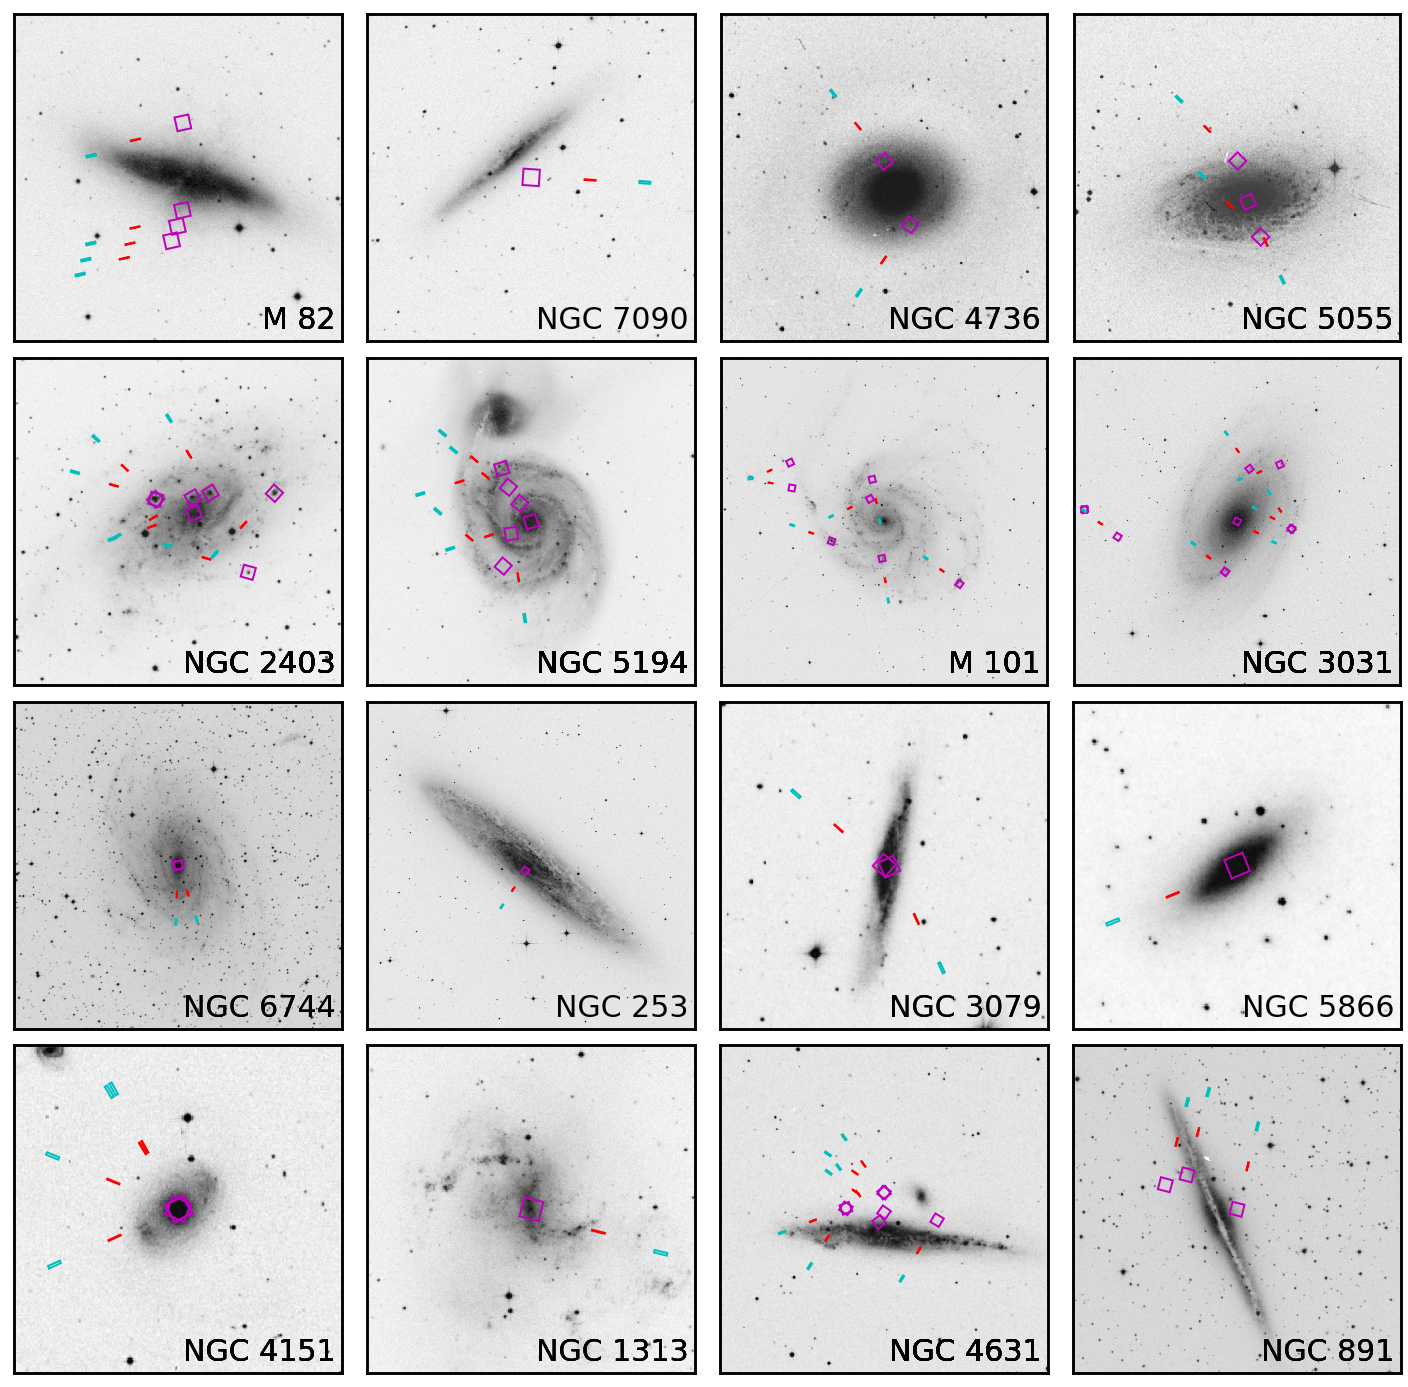

In [16]:
set_rcparams_prop(amp=1.15)

rr=1
aa=6
wrs=np.array([1.8, 0.2, 1.2, 0.05])
hrs=np.array([1])
fig = plt.figure(figsize=(20, 30))
fig = plt.figure(figsize=(25, 25))
ncol=4
nrow=4
gs1 = gridspec.GridSpec(nrow, ncol, figure=fig, 
#                         width_ratios=wrs, height_ratios=hrs,
                        hspace=0.05, wspace=0.05
                       )
pidxs=np.arange(ncol*nrow)
axs=[]
for i in range(len(pidxs)):
    ax=fig.add_subplot(gs1[i // ncol, i%ncol])
    axs.append(ax)


fidx=[0,0,0,0,0,
      0,0,1,0,0,
      0,0,0,0,0,
      0,0,0,0
     ]

cut_widths=np.array([
    350,300,400,400,
    400,400,1400,1600,
    600,1600,300,250,
    250,250,500,400,
])/3600*2


raoffs=np.array(
    [0,0,0,0,
     0.7,0,-0.4,0,
     0,0,0,0,
     0,0,0,0,
    ]
)

decoffs=np.array(
    [0.1,0,-0.05,-0.05,
     -0.1,0,0,0,
     0,0,0,0,
     0,0,-0.05,0,
    ]
)

minsep=0.5
file_sc=SkyCoord(fdf.ra, fdf.dec, frame='icrs', unit='deg')    
for i in range(len(objnames)):
# for i in range(8):
    ax=axs[i]
    objname=objnames[i]
    print(objname)
    sdf=df.loc[df['objname']==objname,:]
    sdf.index=np.arange(len(sdf))
    ra0, dec0=sdf.loc[0,'ra'], sdf.loc[0,'dec']
#     print(ra0, dec0)
    c = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
    cond=np.array(file_sc.separation(c))<minsep
    match_df=fdf[cond]
    match_df.index=np.arange(np.sum(cond))
    fits_file=match_df.loc[fidx[i],'file_path']
    hdu=fits.open(fits_file)
    hdr=hdu[0].header
    oiwcs=astropy.wcs.WCS(header=hdr) 
#     print(fits_file)
    
    cmap=cm.gray_r
    origin='lower'

    oim=hdu[0].data

    ra0, dec0=sdf.loc[0,'ra']+cut_widths[i]*raoffs[i], sdf.loc[0,'dec']+cut_widths[i]*decoffs[i]
#     print(ra0, dec0)
    cc = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
    
    img_cutout_obj=Cutout2D(oim, cc, 
                       u.Quantity(cut_widths[i], unit='deg'),
                       wcs=oiwcs,
                    mode='trim',
#                     mode='partial',
                   )
    im=img_cutout_obj.data
    iwcs=img_cutout_obj.wcs

    
    img=ax.matshow(im, 
               cmap=cmap, 
               origin=origin, interpolation='none', 
#                zorder=1,
#               alpha=alpha, zorder=zorder, aspect=aspect, 
#                norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
                  )
#     print(objname)
    print('npt',len(sdf))
    
    for j in range(len(sdf)):
        jra, jdec=sdf.loc[j,'ra'], sdf.loc[j,'dec']        
        c_obj=SkyCoord(jra, jdec, 
                                          unit='deg',
                                          frame='icrs')
        if sdf.loc[j,'aperture']=='MDRS':
            sep=u.Quantity(-90.18-118.07, unit='arcsec')
            c_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
            print('MDRS!!!')

        sep=u.Quantity(90.18+118.07, unit='arcsec')
        m_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
        sep=u.Quantity(-10.27+118.07, unit='arcsec')
        h_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
         
        objs=[c_obj, m_obj, h_obj]
        xws=[30,4,1.25]
        yws=[30,20,20]
        clrs=['m','c','r']
        
        for k in range(3):
            pcent_x, pcent_y=iwcs.world_to_pixel(objs[k])
            psm=iwcs.pixel_scale_matrix
            pscale=(psm[0,0]**2+psm[0,1]**2)**0.5
    #         print('pscale',pscale)
            pxwidth=xws[k]/3600/pscale
            pywidth=yws[k]/3600/pscale
#             edgecolor='m'
            edgecolor=clrs[k]
    #         edgecolor='k'
            sqlw=2


            rot_ang=0
            rot_ang=sdf.loc[j,'pa']
            recx, recy=rec_rotate(pcent_x, pcent_y, pxwidth, pywidth, rot_ang)
            rec=matplotlib.patches.Rectangle((recx, recy,), pxwidth, pywidth, alpha=1, 
                                             angle=rot_ang,
                                             zorder=20,
        #     rec=matplotlib.patches.Rectangle((pcent_x-pxwidth/2,pcent_y-pywidth/2), pxwidth, pywidth, alpha=1, 
        #                                      angle=(-180),
        #                                   facecolor='w', fill=True)
                                    linewidth=sqlw, edgecolor=edgecolor, linestyle='-', fill=False)
            #                                               linewidth=1.5, edgecolor='w', linestyle=esty[k-1], fill=False)
            art=ax.add_artist(rec)
        ax.text(0.98,0.02,objname,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes,
                size=30
               )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        
#         pcent_x, pcent_y=iwcs.world_to_pixel(m_obj)
#         psm=iwcs.pixel_scale_matrix
#         pscale=(psm[0,0]**2+psm[0,1]**2)**0.5
# #         print('pscale',pscale)
#         pxwidth=4/3600/pscale
#         pywidth=20/3600/pscale
#         edgecolor='c'
# #         edgecolor='k'
#         sqlw=3

        
#         rot_ang=0
#         rot_ang=sdf.loc[j,'pa']
#         recx, recy=rec_rotate(pcent_x, pcent_y, pxwidth, pywidth, rot_ang)
#         rec=matplotlib.patches.Rectangle((recx, recy,), pxwidth, pywidth, alpha=1, 
#                                          angle=rot_ang,
#                                          zorder=20,
#     #     rec=matplotlib.patches.Rectangle((pcent_x-pxwidth/2,pcent_y-pywidth/2), pxwidth, pywidth, alpha=1, 
#     #                                      angle=(-180),
#     #                                   facecolor='w', fill=True)
#                                 linewidth=sqlw, edgecolor=edgecolor, linestyle='-', fill=False)
#         #                                               linewidth=1.5, edgecolor='w', linestyle=esty[k-1], fill=False)
#         art=ax.add_artist(rec)
    
csp=0.0
fig.subplots_adjust(wspace=csp, hspace=csp)

# aa=cc.separation(c)
# np.array(Angle(aa, unit=u.deg))<0.5
match_df
fname='adap_target_pointings2022.pdf'
fig.savefig(fname,dpi=256, bbox_inches='tight')

In [33]:
fdf.ra


0     150.490850000
1     190.533380000
2     192.721090000
3     148.969690000
4     210.802270000
          ...      
87         prv/0001
88         prv/0005
89         prv/0011
90         prv/0008
91         prv/0001
Name: ra, Length: 92, dtype: object

In [ ]:
['obsID',
 'obs_collection',
 'dataproduct_type',
 'obs_id',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project',
 'prvversion',
 'proposal_id',
 'productFilename',
 'size',
 'parent_obsid',
 'dataRights',
 'calib_level']

In [40]:
# print(obs_table)
# np.sum(obs_table['obs_collection']=='FUSE')
obs_table
# products = Observations.get_product_list(obs_table[0])
# products
data_url=obs_table[0]['dataURL']
cdir='./galex_fits/'
fname='_'.join([objname,'galex','fuv'])+'.fits.gz'
print(data_url)
print(cdir+fname)
# urllib.request.urlretrieve(data_url, cdir+fname)

http://galex.stsci.edu/data/GR6/pipe/01-vsn/05249-NGA_NGC4631/d/01-main/0001-img/07-try/NGA_NGC4631-fd-exp.fits.gz
./galex_fits/NGC4631_galex_fuv.fits.gz


In [41]:
obs_table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
str8,int64,str5,str19,str24,float64,float64,float64,float64,float64,str2,str3,float64,float64,str1,str45,float64,str5,str18,str2,str3,str3,int64,str3,str43,str148,str148,str6,bool,float64,str7,str6,str6,str6,float64
image,2,GALEX,2490528114833096704,NGA_NGC4631,190.52676462520594,32.5524440298686,53101.2280787037,54945.26782407408,3147.4,UV,FUV,134000000000.0,180600000000.0,--,--,55327.10020833,GALEX,--,--,NGS,NGS,--,NGS,CIRCLE ICRS 190.52676463 32.55244403 0.625,http://galex.stsci.edu/data/GR6/pipe/01-vsn/05249-NGA_NGC4631/d/01-main/0001-img/07-try/qa/NGA_NGC4631-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/05249-NGA_NGC4631/d/01-main/0001-img/07-try/NGA_NGC4631-fd-exp.fits.gz,PUBLIC,--,5885.0,science,1317,2467,2467,0.0
image,2,GALEX,3057102058579558400,GI1_047080_NGC4656,190.98340608684293,32.1802209818069,53793.70908564815,53793.728437499994,1672.0,UV,FUV,134000000000.0,180600000000.0,--,Demographics of Nearby Star-Forming Galaxies,55310.13631943,GALEX,Robert Kennicutt,25,GII,GII,--,GII,CIRCLE ICRS 190.98340609 32.18022098 0.625,http://galex.stsci.edu/data/GR6/pipe/01-vsn/21352-GI1_047080_NGC4656/d/01-main/0001-img/07-try/qa/GI1_047080_NGC4656-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/21352-GI1_047080_NGC4656/d/01-main/0001-img/07-try/GI1_047080_NGC4656-fd-cnt.fits.gz,PUBLIC,--,5885.0,science,3783,6920,6920,0.0
image,2,GALEX,6374891639999037440,AIS_113_1_47,190.53224574337503,32.2613616213112,53101.722349537034,53119.530231481476,202.05,UV,FUV,134000000000.0,180600000000.0,--,--,55351.2481366,GALEX,--,--,AIS,AIS,--,AIS,CIRCLE ICRS 190.53224574 32.26136162 0.625,http://galex.stsci.edu/data/GR6/pipe/02-vsn/50113-AIS_113/d/01-main/0001-img/07-try/qa/AIS_113_sg47-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/02-vsn/50113-AIS_113/d/01-main/0001-img/07-try/AIS_113_sg47-fd-exp.fits.gz,PUBLIC,--,5885.0,science,17693,28956,28956,0.0
spectrum,2,GALEX,3052741395466950306,GI1_033003_NGC4631_spec,190.52101615188303,32.5393924026165,53436.15452546296,53436.17326388889,1615.34997558594,UV,FUV,134000000000.0,180600000000.0,--,--,56085.73833328,GALEX,--,--,GIS,GIS,--,GIS,POSITION ICRS 190.52101615 32.53939240,http://galex.stsci.edu/data/GR6/pipe/01-vsn/21228-GI1_033003_NGC4631/g/01-main/0001-img/07-try/qa/spjpeg/GI1_033003_NGC4631_id005794-xg-gsp_spc.jpeg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/21228-GI1_033003_NGC4631/g/01-main/0001-img/07-try/qa/spjpeg/GI1_033003_NGC4631_id005794-xg-gsp_spc.jpeg,PUBLIC,--,5885.0,science,179440,311964,311964,38.28177509637956
spectrum,2,GALEX,3052741395466959277,GI1_033003_NGC4631_spec,190.518932639553,32.5388192638796,53436.15452546296,53436.17326388889,1615.34997558594,UV,FUV,134000000000.0,180600000000.0,--,--,56085.73833328,GALEX,--,--,GIS,GIS,--,GIS,POSITION ICRS 190.51893264 32.53881926,http://galex.stsci.edu/data/GR6/pipe/01-vsn/21228-GI1_033003_NGC4631/g/01-main/0001-img/07-try/qa/spjpeg/GI1_033003_NGC4631_id014765-xg-gsp_spc.jpeg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/21228-GI1_033003_NGC4631/g/01-main/0001-img/07-try/qa/spjpeg/GI1_033003_NGC4631_id014765-xg-gsp_spc.jpeg,PUBLIC,--,5885.0,science,179548,312180,312180,44.895130812902146
spectrum,2,GALEX,3064528160116709026,GI1_085004_NGC4631_spec,190.52101615188303,32.5393924026165,53436.08604166667,53469.66239583334,979.0,UV,FUV,134000000000.0,180600000000.0,--,--,56086.10009259,GALEX,--,--,GIS,GIS,--,GIS,POSITION ICRS 190.52101615 32.53939240,http://galex.stsci.edu/data/GR6/pipe/01-vsn/21563-GI1_085004_NGC4631/g/01-main/0001-img/07-try/qa/spjpeg/GI1_085004_NGC4631_id005794-xg-gsp_spc.jpeg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/215

In [38]:
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from matplotlib import ticker
# import dotifs_util as util
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoLocator, FixedLocator,
                               AutoMinorLocator)
# import util
from scipy.optimize import curve_fit


import numpy as np
from scipy import constants
from scipy.interpolate import interp1d
import time
from os import path, getcwd
#from os import getcwd
import inspect
from math import pi
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from scipy.signal import convolve as scipyconvolve
import glob
stof=2*(2*np.log(2))**0.5

from astropy.io import fits

import math
import healpy as hp
import pylab

from astropy import units as u
from astropy.coordinates import SkyCoord


# from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

import csv
import numpy as np
import extinction
import requests
import pandas as pd
from PIL import Image, ImageDraw, ImageFilter
#import time
import os
from astroquery.simbad import Simbad
from astropy import units as u

import warnings
warnings.filterwarnings("ignore")


In [39]:
def set_rcparams_prop(amp=1, fs=22):
#     fs=18
    tickmajorwidth=2.5*amp
    tickminorwidth=2.5*amp
    axeslw=2.5*amp
    tmjs=6*amp
    tmns=tmjs/3.5*2*amp
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

In [40]:
# df_sim = Simbad.query_object(galaxies['Object Name'][i])
df_sim = Simbad.query_object('NGC 4631')

In [41]:
df_sim.columns
# df_sim.loc['RA',:]
print(df_sim['RA'], df_sim['DEC'])
coords = SkyCoord(df_sim['RA'], df_sim['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
# coords = SkyCoord(df_sim['RA'], df_sim['DEC'], frame='icrs')
coords

     RA     
  "h:m:s"   
------------
12 42 08.009     DEC     
  "d:m:s"   
------------
+32 32 29.44


<SkyCoord (ICRS): (ra, dec) in deg
    [(190.53337083, 32.54151111)]>

In [42]:
gal_list=[
    "NGC 4631",
    "NGC 3003",
    "NGC 891",
    "NGC 5746",
    "NGC 1353",
    "NGC 253",
    "NGC 3692",
    "NGC 3044",
    "NGC 5775",
    "NGC 4666",
    "NGC 625",
    "NGC 7064",
    "NGC 1406",
    "NGC 1448",
    "NGC 660",
    "IC 5052",
    "M82",
    "NGC 7582",
]

In [48]:
df_res=Simbad.query_objects(gal_list)
coords = SkyCoord(df_res['RA'], df_res['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
coords

gdf=pd.DataFrame({
    'name':df_res['MAIN_ID'],   
    'ra':coords.ra.degree,
    'dec':coords.dec.degree,
    'l':coords.galactic.l.degree,
    'b':coords.galactic.b.degree,
})
gdf



,name,ra,dec,l,b
0,NGC 4631,190.533371,32.541511,142.805267,84.223429
1,NGC 3003,147.148250,33.421619,192.342011,50.340097
2,NGC 891,35.637112,42.348319,140.382248,-17.415247
3,NGC 5746,221.233354,1.954739,354.966065,52.955474
4,NGC 1353,53.012600,-20.819161,212.034226,-52.929058
5,NGC 253,11.888058,-25.288800,97.363851,-87.964547
6,NGC 3692,172.100221,9.407750,251.132096,63.579153
7,NGC 3044,148.420350,1.579650,236.196991,40.374071
8,NGC 5775,223.490221,3.544472,359.431956,52.422806
9,NGC 4666,191.286150,-0.461911,299.538115,62.368359


In [49]:
def under_sample(arr):
    iarr=arr[[np.arange(len(arr)//4)*4]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+1]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+2]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+3]]
    return iarr/4

def under_sample(arr):
    val0=arr[[np.arange(len(arr)//4)*4]]
    val1=arr[[np.arange(len(arr)//4)*4+1]]
    val2=arr[[np.arange(len(arr)//4)*4+2]]
    val3=arr[[np.arange(len(arr)//4)*4+3]]
    tval=val0+val1+val2+val3
    non0=(val0>0)*1+(val1>0)*1+(val2>0)*1+(val3>0)*1
    tval=tval/non0
    tval[non0==0]=0
    return tval


def mag2flam(mag, zero_pt=21.1, ABwave=None):
    if np.any(ABwave != None):
        return 10.**(-0.4*(mag+2.406+5*np.log10(ABwave)))
    return 10.**(-0.4*(mag+zero_pt))

In [51]:
lon_plot=np.radians(360-gdf['l'])
lat_plot=np.radians((gdf['b']))
lon_plot[lon_plot>np.pi]=lon_plot[lon_plot>np.pi]-2*np.pi

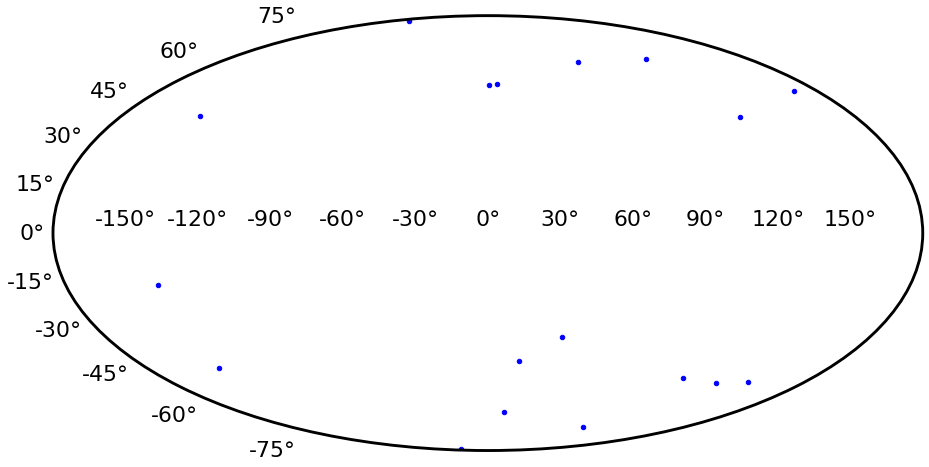

In [59]:
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection="mollweide")

markersize=1

# rplon=np.radians(lon_plot)
# rplat=np.radians(lat_plot)
# rplon[rplon>np.pi]=rplon[rplon>np.pi]-2*np.pi

ax.scatter(lon_plot, lat_plot,
# ax.scatter(plon, plat,
#             -aspera_targets_ra.wrap_at(180 * u.deg).radian,
#             aspera_targets_dec.radian,
            marker="o",
            s=markersize*20,
            c="blue",
#             label='Aspera Science Targets'
            )

# odf=pd.DataFrame({
#     'gal_lon':plon,
#     'gal_lat':plat,}
# )
# print(len(odf))
# odf.to_csv('nox_target_coord_galactic.csv')

In [60]:
gdf

,name,ra,dec,l,b
0,NGC 4631,190.533371,32.541511,142.805267,84.223429
1,NGC 3003,147.148250,33.421619,192.342011,50.340097
2,NGC 891,35.637112,42.348319,140.382248,-17.415247
3,NGC 5746,221.233354,1.954739,354.966065,52.955474
4,NGC 1353,53.012600,-20.819161,212.034226,-52.929058
5,NGC 253,11.888058,-25.288800,97.363851,-87.964547
6,NGC 3692,172.100221,9.407750,251.132096,63.579153
7,NGC 3044,148.420350,1.579650,236.196991,40.374071
8,NGC 5775,223.490221,3.544472,359.431956,52.422806
9,NGC 4666,191.286150,-0.461911,299.538115,62.368359
